In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models
import time

VGG19 network was initially developed for image classification competition ImageNet ILSVRC-2014, scoring 7.3% error rate. That was a breakthrough of the year. VGG19 is simple, fast and easy to understand. It has 5 stacks of convolutional layers named accordingly conv1 to conv5, each having from 2 to 4 layers, named conv1_2…conv5_4. They are followed by fully connected layers, that are actually doing classification.

The idea behind is simple — convolutional layers do “feature extraction” acting as perception fields, finding patterns and geometrical shapes of progressing complexity and fully connected layers act as a classical perceptron, classifying objects based on what shapes were present in the image.

Now we will import the style and content images. The original PIL images have values between 0 and 255, but when transformed into torch tensors, their values are converted to be between 0 and 1. The images also need to be resized to have the same dimensions. An important detail to note is that neural networks from the torch library are trained with tensor values ranging from 0 to 1. If you try to feed the networks with 0 to 255 tensor images, then the activated feature maps will be unable sense the intended content and style. However, pre-trained networks from the Caffe library are trained with 0 to 255 tensor images.

In [9]:
imsize = 512 if torch.cuda.is_available() else 256  # use small size if no gpu
def load_image(img_path, max_size=imsize, shape=None):
    image = Image.open(img_path).convert('RGB')
    
    if max(image.size)>max_size:
        size=max_size
    else:
        size=max(image.size)
    in_transform = transforms.Compose([
        transforms.Resize((size, int(1.5*size))),
        transforms.ToTensor(), # to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
        transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))])  # normalize tensor, mean, std, 
    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0) # add dimension at the beginning (zero place)
    
    return(image)

In [10]:
style = load_image('cubism.jpg')
style.shape

torch.Size([1, 3, 256, 384])

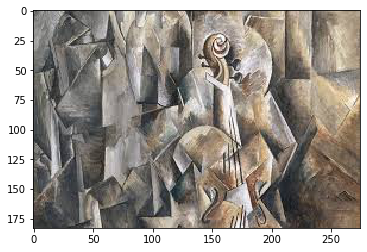

In [11]:
# show original style picture
img=mpimg.imread('cubism.jpg')
imgplot = plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 383.5, 255.5, -0.5)

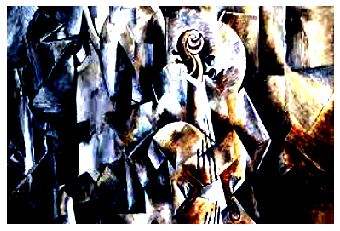

In [12]:
# show image after transforming/normalizing/RGM with load image function
fig = plt.figure()
plt.imshow(style.numpy().squeeze(0).transpose(1,2,0))
plt.axis('off')

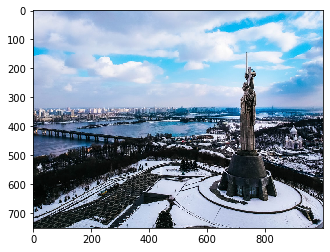

In [13]:
# show original content picture
img=mpimg.imread('ukr.jpg')
imgplot = plt.imshow(img)
plt.show()

In [14]:
def im_convert(tensor):
    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image*np.array((0.229,0.224,0.225))+np.array((0.485,0.456,0.406))
    image = image.clip(0,1)
    return image

In [15]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1','5':'conv2_1',
                 '10':'conv3_1',
                 '19': 'conv4_1',
                 '21': 'conv4_2', # content layer
                 '28': 'conv5_1'}
    features = {}
    x = image
    for name, layer in enumerate(model.features):
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x
            
    return features

In [16]:
def gram_matrix(tensor):
    # get the batch_size, depth, height, and width of the Tensor
    _, n_filters, h, w = tensor.size()
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(n_filters, h*w)
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [17]:
vgg19 = models.vgg19()

vgg19.load_state_dict(torch.utils.model_zoo.load_url('https://download.pytorch.org/models/vgg19-dcbb9e9d.pth'))

<All keys matched successfully>

In [18]:
# freeze all VGG parameters since we're only optimizing the target image
for param in vgg19.parameters():
    param.requires_grad_(False)

In [19]:
for i, layer in enumerate(vgg19.features):
    if isinstance(layer, torch.nn.MaxPool2d):
        vgg19.features[i]=torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

In [20]:
torch.cuda.is_available()

False

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg19.to(device).eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): AvgPool

# Loading the Content image

In [32]:
content = load_image('ukr.jpg').to(device)
style = style.to(device)

content_features = get_features(content, vgg19)
style_features = get_features(style, vgg19)

In [33]:
# gram_matrix for each layer in the style_features
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [34]:
target = torch.randn_like(content).requires_grad_(True).to(device)
# target = content.clone().requires_grad_(True).to(device)

#  A Loss Function of Artistic Style

In [50]:
style_weights = {'conv1_1': 0.75,
                'conv2_1': 0.5,
                'conv3_1': 0.2,
                'conv4_1': 0.2,
                'conv5_1':0.2}

In [51]:
content_weight = 1e36
style_weight = 1e3

The loss function or optimization target is set to be the content loss using representation from VGG layer conv4_2 plus the style loss using representation from VGG layers conv1_1, conv2_1, conv3_1, conv4_1, and conv5_1. These layers, as presented by Gatys, were found to yield the best results.

# The Style Transfer Loop

In [52]:
optimizer = optim.Adam([target], lr=0.01) # The original paper reports using an L-BFGS optimizer

In [53]:
num_iterations = 500

In [54]:
start = time.time()
for i in range(1, num_iterations+1):
    optimizer.zero_grad()
    target_features = get_features(target, vgg19)
    
    content_loss = torch.mean((target_features['conv4_2']-content_features['conv4_2'])**2)
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram= gram_matrix(target_feature)
        _,d,h,w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer]*torch.mean((target_gram - style_gram)**2)
        style_loss+=layer_style_loss/(d*h*w)
        
    total_loss = content_weight*content_loss+style_weight*style_loss
    total_loss.backward(retain_graph = True)
    optimizer.step()
        
    if i%10==0:
        total_loss_rounded = round(total_loss.item(),2)
        content_fraction = round(content_weight*content_loss.item()/total_loss.item(),2)
        style_fraction = round(style_weight*style_loss.item()/total_loss.item(),2)
        print('Iteration {}, Total loss: {} - (content: {}, style {})'.format(i, total_loss_rounded, content_fraction,
                                                                                style_fraction))
end = time.time()
time_proc = end - start
print('time needed: ', round(time_proc,3))
final_img = im_convert(target)

Iteration 10, Total loss: 7.7390592049806e+35 - (content: 1.0, style 0.0)
Iteration 20, Total loss: 7.7390592049806e+35 - (content: 1.0, style 0.0)
Iteration 30, Total loss: 7.7390592049806e+35 - (content: 1.0, style 0.0)
Iteration 40, Total loss: 7.7390592049806e+35 - (content: 1.0, style 0.0)
Iteration 50, Total loss: 7.7390592049806e+35 - (content: 1.0, style 0.0)
Iteration 60, Total loss: 7.7390592049806e+35 - (content: 1.0, style 0.0)
Iteration 70, Total loss: 7.7390592049806e+35 - (content: 1.0, style 0.0)
Iteration 80, Total loss: 7.7390592049806e+35 - (content: 1.0, style 0.0)
Iteration 90, Total loss: 7.7390592049806e+35 - (content: 1.0, style 0.0)
Iteration 100, Total loss: 7.7390592049806e+35 - (content: 1.0, style 0.0)
Iteration 110, Total loss: 7.7390592049806e+35 - (content: 1.0, style 0.0)
Iteration 120, Total loss: 7.7390592049806e+35 - (content: 1.0, style 0.0)
Iteration 130, Total loss: 7.7390592049806e+35 - (content: 1.0, style 0.0)
Iteration 140, Total loss: 7.73905

In [48]:
final_img = im_convert(target)

(-0.5, 383.5, 255.5, -0.5)

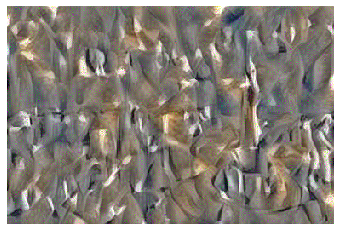

In [49]:
# 3800 iterations
fig = plt.figure()
plt.imshow(final_img)
plt.axis('off')

(-0.5, 191.5, 127.5, -0.5)

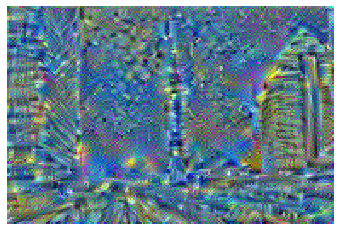

In [23]:
# 400 iterations (this examples is for other pictures)
fig = plt.figure()
plt.imshow(final_img)
plt.axis('off')

In [63]:
final_img.shape

(400, 600, 3)

In [44]:
round(y,1)

6.4